### A Analysis Notebook for Classical MD
1.concert lammps-data to pdb -traj to dcd
2.make plumed.dat input
3.analysis and plot

contact me:
qihaoxiaoai@gmail

In [2]:
%%time
import plumed
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import MDAnalysis
import numpy as np
import math
import mdtraj
import scipy
import sys
import subprocess
import glob

/home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 641 ms, sys: 465 ms, total: 1.11 s
Wall time: 499 ms


In [2]:
#convert traj for plumed
demomdt=mdtraj.load_lammpstrj("traj.lammpstrj",top= 'demo.pdb', unit_set='real')
demomdt.save_dcd("mdt.dcd")

/home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:198: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [35]:
#make plumed.dat
#for base-pair of two-strand
def make_plumed_input(num_bp, strand):
    atom_pairs = []
    if strand == "d":
        s1 = [i*3 + 1 for i in range(num_bp)]
        s2 = [i*3 + num_bp*3 for i in range(num_bp)]
        for idx, (b1, b2) in enumerate(zip(s1, reversed(s2))):
            atom_pairs.append((b1, b2))
    else:
        print("not developed yet!")
    pairlist= '#pair_distance \nMOLINFO STRUCTURE=demo.pdb\nWHOLEMOLECULES ENTITY0=1-58\n'
    paird = 'd1: DISTANCES'
    plumed_out ='PRINT ARG='
   
    # add each pair with plumed ormat
    for i, pair in enumerate(atom_pairs):
        pairlist +=f'p{i+1}: DISTANCE ATOMS={pair[0]},{pair[1]} \n'
        paird += f' ATOMS{i+1}={pair[0]},{pair[1]}'
        plumed_out += f'p{i+1},'
    paird += ' MEAN\n'
    plumed_out_pure = plumed_out+ 'd1.mean STRIDE=100 FILE=COLVAR \n'
    plumed_out +='d1.mean,metad.bias STRIDE=5000 FILE=COLVAR \n'
    plumed_para ='METAD ...\nLABEL=metad\nARG=d1.mean  # take the mean of all distanes\nPACE=1000\nHEIGHT=0.6 #1.2\nSIGMA=0.01 #0.35\nFILE=HILLS\nBIASFACTOR=4\nTEMP=315.0\nGRID_MIN=0.45\nGRID_MAX=7.5\n... METAD\n'
    return pairlist,paird,plumed_out,plumed_para,plumed_out_pure
#for shifit-base-pair of two-strand-n(n-1)
def make_plumed_input_nn(num_bp, strand):
    atom_pairs = []
    if strand == "d":
#         s1 = [i*3 + 1 for i in range(num_bp)]
#         s2 = [i*3 + num_bp*3 for i in range(num_bp)]
        s3 = [i*3 + 1 for i in range(num_bp-1)]
        s4 = [i*3 + num_bp*3 for i in range(num_bp-1)]
        for idx, (b1, b2) in enumerate(zip(s3, reversed(s4))):
            atom_pairs.append((b1, b2))
#             print(s3)
#             print(s4)
#             print(s1)
#             print(s2)
#             print("********")
    else:
        print("not developed yet!")
    pairlist= '#pair_distance \n'
    paird = 'd1: DISTANCES'
    plumed_out ='PRINT ARG='
   
    # add each pair with plumed ormat
    for i, pair in enumerate(atom_pairs):
        pairlist +=f'p{i+1}: DISTANCE ATOMS={pair[0]},{pair[1]} \n'
        paird += f' ATOMS{i+1}={pair[0]},{pair[1]}'
        plumed_out += f'p{i+1},'
    paird += ' MEAN\n'
    plumed_out_pure = plumed_out+ 'd1.mean STRIDE=100 FILE=COLVAR \n'
    plumed_out +='d1.mean,metad.bias STRIDE=5000 FILE=COLVAR \n'
    plumed_para ='METAD ...\nLABEL=metad\nARG=d1.mean  # take the mean of all distanes\nPACE=1000\nHEIGHT=0.6 #1.2\nSIGMA=0.01 #0.35\nFILE=HILLS\nBIASFACTOR=4\nTEMP=315.0\nGRID_MIN=0.45\nGRID_MAX=7.5\n... METAD\n'
    return pairlist,paird,plumed_out,plumed_para,plumed_out_pure

In [36]:
# #for on-the-fly run-with lammps(plumed version < 2.6 patch the plumed to lammps)
# atom_pairs = make_plumed_input(30,"d")
# with open(f'bp-plumed.dat', 'w') as f:
#     f.write(atom_pairs[0])
#     f.write(atom_pairs[1])
#     f.write(atom_pairs[3])
#     f.write(atom_pairs[2])
#     f.close()
# nn_pairs=make_plumed_input_nn(10,"d")
# with open(f'nn-10-plumed.dat', 'w') as f:
#     f.write(nn_pairs[0])
#     f.write(nn_pairs[1])
#     f.write(nn_pairs[3])
#     f.write(nn_pairs[2])
#     f.close()
#for only-analysis,param-(num of bp,double or other strand)
atom_pairs = make_plumed_input(10,"d")
with open(f'plumed.dat', 'w') as f:
    f.write(atom_pairs[0])
    f.write(atom_pairs[1])
    f.write(atom_pairs[4])
    f.close()

In [37]:
!plumed driver --plumed plumed.dat --mf_dcd demo.dcd


DRIVER: Found molfile format trajectory dcd with name demo.dcd
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/plumed
PLUMED: For installed feature, see /home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 58
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named demo.pdb contains 1 chains 
PLUMED:   chain named D contains res

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/libplumedKernel.so" +++


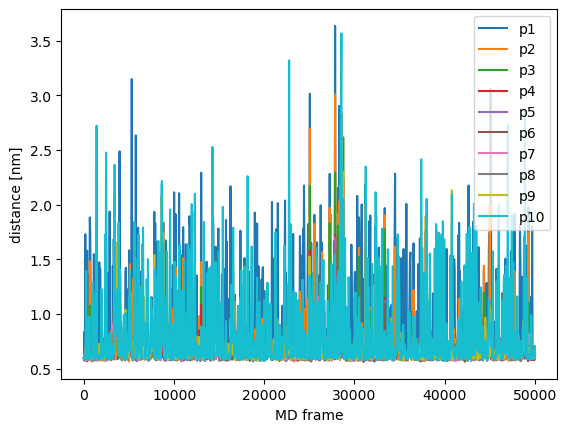

In [5]:
# import PLUMED COLVAR file into pandas dataset
data=plumed.read_as_pandas("COLVAR")
# plot time serie of distances to glycans
plt.plot(data["time"],data["p1"],label="p1")
plt.plot(data["time"],data["p2"],label="p2")
plt.plot(data["time"],data["p3"],label="p3")
plt.plot(data["time"],data["p4"],label="p4")
plt.plot(data["time"],data["p5"],label="p5")
plt.plot(data["time"],data["p6"],label="p6")
plt.plot(data["time"],data["p7"],label="p7")
plt.plot(data["time"],data["p8"],label="p8")
plt.plot(data["time"],data["p9"],label="p9")
plt.plot(data["time"],data["p10"],label="p10")

# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("distance [nm]")
plt.legend()
# # calculate when lig is closer to g1 than g2
# count=0.
# for i in range(0, len(data["time"])):
#     if(data["d1"][i]<=data["d2"][i]): count+=1.0
# print("Percentage of frames with lig closer to g1 than g2: %4.1lf" % (count/float(len(data["time"]))*100.0))

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/libplumedKernel.so" +++


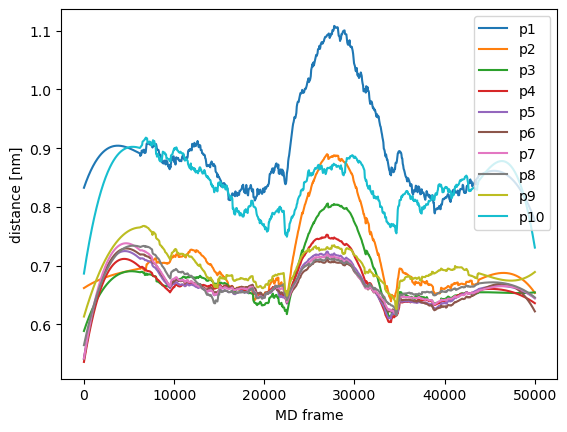

In [12]:
data=plumed.read_as_pandas("COLVAR")
tmp_smooth1 = scipy.signal.savgol_filter(data["p1"],250,3)
tmp_smooth2 = scipy.signal.savgol_filter(data["p2"],250,3)
tmp_smooth3 = scipy.signal.savgol_filter(data["p3"],250,3)
tmp_smooth4 = scipy.signal.savgol_filter(data["p4"],250,3)
tmp_smooth5 = scipy.signal.savgol_filter(data["p5"],250,3)
tmp_smooth6 = scipy.signal.savgol_filter(data["p6"],250,3)
tmp_smooth7 = scipy.signal.savgol_filter(data["p7"],250,3)
tmp_smooth8 = scipy.signal.savgol_filter(data["p8"],250,3)
tmp_smooth9 = scipy.signal.savgol_filter(data["p9"],250,3)
tmp_smooth10 = scipy.signal.savgol_filter(data["p10"],250,3)
# plot time serie of distances to glycans
# plt.plot(data["time"],data["p1"],label="p1")
# plt.plot(data["time"],data["p2"],label="p2")
# plt.plot(data["time"],data["p3"],label="p3")
# plt.plot(data["time"],data["p4"],label="p4")
# plt.plot(data["time"],data["p5"],label="p5")
# plt.plot(data["time"],data["p6"],label="p6")
# plt.plot(data["time"],data["p7"],label="p7")
# plt.plot(data["time"],data["p8"],label="p8")
# plt.plot(data["time"],data["p9"],label="p9")
# plt.plot(data["time"],data["p10"],label="p10")
plt.plot(data["time"],tmp_smooth1,label="p1")
plt.plot(data["time"],tmp_smooth2,label="p2")
plt.plot(data["time"],tmp_smooth3,label="p3")
plt.plot(data["time"],tmp_smooth4,label="p4")
plt.plot(data["time"],tmp_smooth5,label="p5")
plt.plot(data["time"],tmp_smooth6,label="p6")
plt.plot(data["time"],tmp_smooth7,label="p7")
plt.plot(data["time"],tmp_smooth8,label="p8")
plt.plot(data["time"],tmp_smooth9,label="p9")
plt.plot(data["time"],tmp_smooth10,label="p10")
# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("distance [nm]")
plt.legend()

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/libplumedKernel.so" +++


Text(0.5, 1.0, 'Base-Pair Distance')

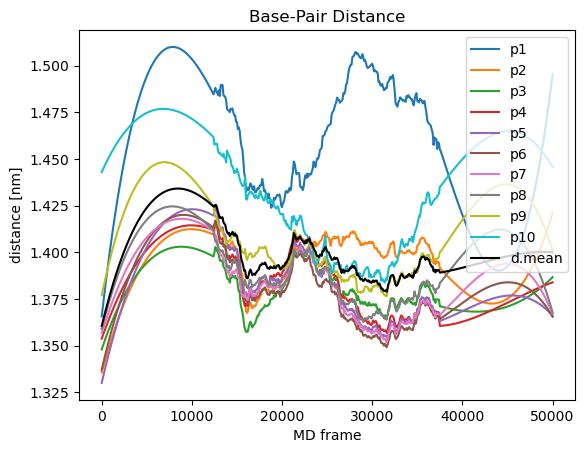

In [6]:
data=plumed.read_as_pandas("COLVAR")
tmp_smooth1 = scipy.signal.savgol_filter(data["p1"],250,3)
tmp_smooth2 = scipy.signal.savgol_filter(data["p2"],250,3)
tmp_smooth3 = scipy.signal.savgol_filter(data["p3"],250,3)
tmp_smooth4 = scipy.signal.savgol_filter(data["p4"],250,3)
tmp_smooth5 = scipy.signal.savgol_filter(data["p5"],250,3)
tmp_smooth6 = scipy.signal.savgol_filter(data["p6"],250,3)
tmp_smooth7 = scipy.signal.savgol_filter(data["p7"],250,3)
tmp_smooth8 = scipy.signal.savgol_filter(data["p8"],250,3)
tmp_smooth9 = scipy.signal.savgol_filter(data["p9"],250,3)
tmp_smooth10 = scipy.signal.savgol_filter(data["p10"],250,3)
tmp_smooth11 = scipy.signal.savgol_filter(data["d1.mean"],250,3)
# plot time serie of distances to glycans
# plt.plot(data["time"],data["p1"],label="p1")
# plt.plot(data["time"],data["p2"],label="p2")
# plt.plot(data["time"],data["p3"],label="p3")
# plt.plot(data["time"],data["p4"],label="p4")
# plt.plot(data["time"],data["p5"],label="p5")
# plt.plot(data["time"],data["p6"],label="p6")
# plt.plot(data["time"],data["p7"],label="p7")
# plt.plot(data["time"],data["p8"],label="p8")
# plt.plot(data["time"],data["p9"],label="p9")
# plt.plot(data["time"],data["p10"],label="p10")
plt.plot(data["time"],tmp_smooth1,label="p1")
plt.plot(data["time"],tmp_smooth2,label="p2")
plt.plot(data["time"],tmp_smooth3,label="p3")
plt.plot(data["time"],tmp_smooth4,label="p4")
plt.plot(data["time"],tmp_smooth5,label="p5")
plt.plot(data["time"],tmp_smooth6,label="p6")
plt.plot(data["time"],tmp_smooth7,label="p7")
plt.plot(data["time"],tmp_smooth8,label="p8")
plt.plot(data["time"],tmp_smooth9,label="p9")
plt.plot(data["time"],tmp_smooth10,label="p10")
plt.plot(data["time"],tmp_smooth11,label="d.mean",color='black')
# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("distance [nm]")
plt.legend()
plt.title("Base-Pair Distance", fontsize=12)

In [11]:
def make_plumed_input_bb(num_bp, strand):
    atom_pairs = []
    if strand == "d":
        s1 = [i*3 + 2 for i in range(num_bp)]
        s2 = [i*3 + 1+ num_bp*3 for i in range(num_bp)]
        for idx, (b1, b2) in enumerate(zip(s1, reversed(s2))):
            atom_pairs.append((b1, b2))
    else:
        print("not developed yet!")
    pairlist= '#pair_distance \nMOLINFO STRUCTURE=demo.pdb\nWHOLEMOLECULES ENTITY0=1-58\nrg: GYRATION ATOMS=1-58\n'
    paird = 'd1: DISTANCES'
    plumed_out ='PRINT ARG='
   
    # add each pair with plumed ormat
    for i, pair in enumerate(atom_pairs):
        pairlist +=f'p{i+1}: DISTANCE ATOMS={pair[0]},{pair[1]} \n'
        paird += f' ATOMS{i+1}={pair[0]},{pair[1]}'
        plumed_out += f'p{i+1},'
    paird += ' MEAN\n'
    plumed_out_pure = plumed_out+ 'd1.mean,rg STRIDE=100 FILE=COLVAR3 \n'
    plumed_out +='d1.mean,metad.bias STRIDE=5000 FILE=COLVAR \n'
    plumed_para ='METAD ...\nLABEL=metad\nARG=d1.mean  # take the mean of all distanes\nPACE=1000\nHEIGHT=0.6 #1.2\nSIGMA=0.01 #0.35\nFILE=HILLS\nBIASFACTOR=4\nTEMP=315.0\nGRID_MIN=0.45\nGRID_MAX=7.5\n... METAD\n'
    return pairlist,paird,plumed_out,plumed_para,plumed_out_pure
atom_pairs = make_plumed_input_bb(10,"d")
with open(f'plumed_bb.dat', 'w') as f:
    f.write(atom_pairs[0])
    f.write(atom_pairs[1])
    f.write(atom_pairs[4])
    f.close()
!plumed driver --plumed plumed_bb.dat --mf_dcd demo.dcd


DRIVER: Found molfile format trajectory dcd with name demo.dcd
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/plumed
PLUMED: For installed feature, see /home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 58
PLUMED: File suffix: 
PLUMED: FILE: plumed_bb.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named demo.pdb contains 1 chains 
PLUMED:   chain named D contains 

In [9]:
!plumed driver --plumed plumed_bb.dat --mf_dcd demo.dcd


DRIVER: Found molfile format trajectory dcd with name demo.dcd
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/plumed
PLUMED: For installed feature, see /home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 58
PLUMED: File suffix: 
PLUMED: FILE: plumed_bb.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named demo.pdb contains 1 chains 
PLUMED:   chain named D contains 

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/libplumedKernel.so" +++


Text(0.5, 1.0, 'Base-Pair Distance')

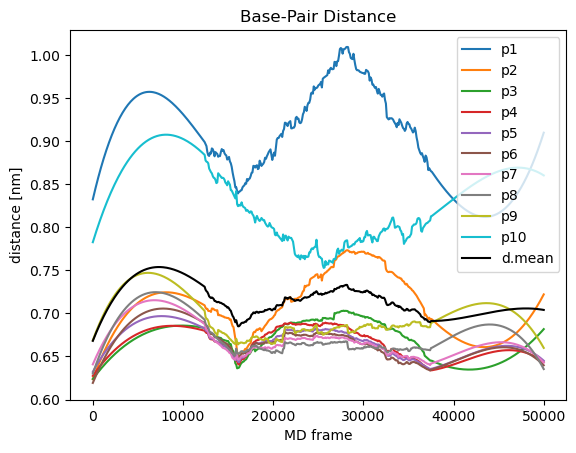

In [10]:
data=plumed.read_as_pandas("COLVAR2")
tmp_smooth1 = scipy.signal.savgol_filter(data["p1"],250,3)
tmp_smooth2 = scipy.signal.savgol_filter(data["p2"],250,3)
tmp_smooth3 = scipy.signal.savgol_filter(data["p3"],250,3)
tmp_smooth4 = scipy.signal.savgol_filter(data["p4"],250,3)
tmp_smooth5 = scipy.signal.savgol_filter(data["p5"],250,3)
tmp_smooth6 = scipy.signal.savgol_filter(data["p6"],250,3)
tmp_smooth7 = scipy.signal.savgol_filter(data["p7"],250,3)
tmp_smooth8 = scipy.signal.savgol_filter(data["p8"],250,3)
tmp_smooth9 = scipy.signal.savgol_filter(data["p9"],250,3)
tmp_smooth10 = scipy.signal.savgol_filter(data["p10"],250,3)
tmp_smooth11 = scipy.signal.savgol_filter(data["d1.mean"],250,3)
# plot time serie of distances to glycans
# plt.plot(data["time"],data["p1"],label="p1")
# plt.plot(data["time"],data["p2"],label="p2")
# plt.plot(data["time"],data["p3"],label="p3")
# plt.plot(data["time"],data["p4"],label="p4")
# plt.plot(data["time"],data["p5"],label="p5")
# plt.plot(data["time"],data["p6"],label="p6")
# plt.plot(data["time"],data["p7"],label="p7")
# plt.plot(data["time"],data["p8"],label="p8")
# plt.plot(data["time"],data["p9"],label="p9")
# plt.plot(data["time"],data["p10"],label="p10")
plt.plot(data["time"],tmp_smooth1,label="p1")
plt.plot(data["time"],tmp_smooth2,label="p2")
plt.plot(data["time"],tmp_smooth3,label="p3")
plt.plot(data["time"],tmp_smooth4,label="p4")
plt.plot(data["time"],tmp_smooth5,label="p5")
plt.plot(data["time"],tmp_smooth6,label="p6")
plt.plot(data["time"],tmp_smooth7,label="p7")
plt.plot(data["time"],tmp_smooth8,label="p8")
plt.plot(data["time"],tmp_smooth9,label="p9")
plt.plot(data["time"],tmp_smooth10,label="p10")
plt.plot(data["time"],tmp_smooth11,label="d.mean",color='black')
# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("distance [nm]")
plt.legend()
plt.title("Base-Pair Distance", fontsize=12)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/libplumedKernel.so" +++


Text(0.5, 1.0, 'Rgration of radius')

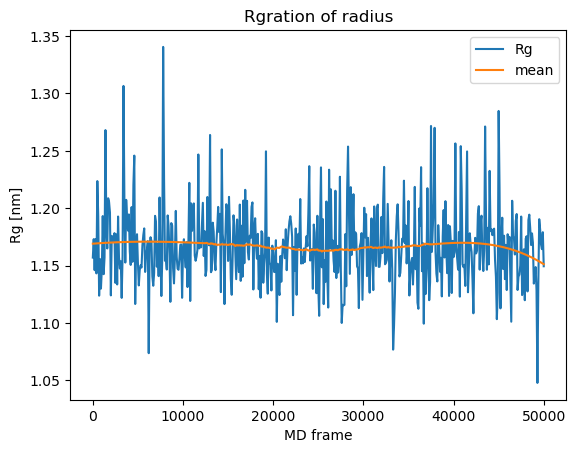

In [16]:
data=plumed.read_as_pandas("COLVAR3")
tmp_smooth10 = scipy.signal.savgol_filter(data["rg"],250,3)
plt.plot(data["time"],data["rg"],label="Rg")
plt.plot(data["time"],tmp_smooth10,label="mean")
# plt.plot(data["time"],data["d1.mean"],label="d.mean")
# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("Rg [nm]")
plt.legend()
plt.title("Rgration of radius", fontsize=12)

Text(0, 0.5, 'distance of 1 & 40 [nm]')

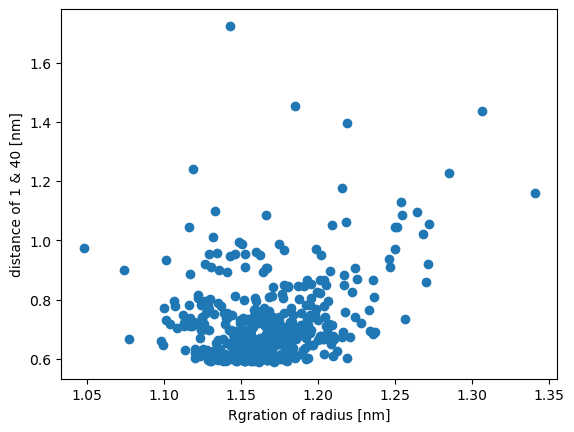

In [17]:
# plot gyration radius vs distance
plt.plot(data["rg"],data["d1.mean"],'o')
# x-y axis labels
plt.xlabel("Rgration of radius [nm]")
plt.ylabel("distance of 1 & 40 [nm]")

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/racy/.pyenv/versions/miniconda3-4.7.12/envs/plu/lib/libplumedKernel.so" +++


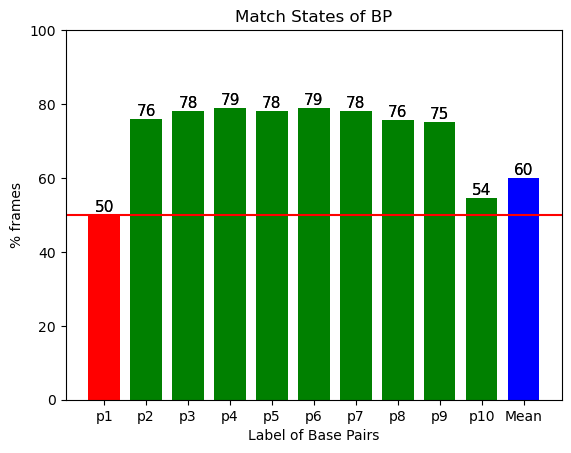

In [7]:
# mpl.rcParams['xtick.labelsize'] = 10
# mpl.rcParams['ytick.labelsize'] = 10
# mpl.rc('font',family='Times New Roman')
# plt.rcParams['mathtext.fontset']='cm'
data2=plumed.read_as_pandas("COLVAR3")
bar=[]
for i in range(1,11):
    count=0.
    for d in data["p"+str(i)]:
        if(d<0.7):count+=1.0
    bar.append(count)
count=0.
for d in data['d1.mean']:
    if(d<0.7):count+=1.0
bar.append(count)
line=bar[0]
parct = bar[0] / float(len(data["time"])) * 100.0
for i in range(0,11):
    bar[i]=bar[i]/line
    bar[i]=bar[i]*parct
ind=range(0,11)
plt.bar(ind[0:-1],bar[0:10],0.75,color="g")
plt.bar(ind[-1:],bar[-1:],0.75,color="b")
plt.axhline(y=50, color='r', linestyle='-')
plt.ylim(0,100)
for a,b in zip(ind,bar):  
    plt.text(a, b+0.05,'%.0f' %b, ha='center', va= 'bottom',fontsize=11)  
for a,b in zip(ind,bar):  
    plt.text(a, b+0.05,'%.0f' %b, ha='center', va= 'bottom',fontsize=11)  
for i in range(0,10):
    if(bar[i])<50:
        plt.bar(ind[i],bar[i],0.75,color="r")
lab = ["Mean"]; ticks=[0]
for i in range(1,11):
    lab.append("p"+str(i))
    ticks.append(i)
for i in range(len(lab)):
    lab.insert(0,lab.pop())
labtot=lab.pop(0)
lab.append(labtot)
plt.xticks(ticks, lab)
plt.ylabel("% frames")
plt.xlabel("Label of Base Pairs")
plt.title("Match States of BP", fontsize=12)
plt.savefig('./filename.s', format='svg') 